# Synthetic Data

# Part A-B-C

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import linear_model
from sklearn.linear_model import Ridge,LinearRegression, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import resample

# Define Franke's function
def FrankeFunction(x, y):
    term1 = 0.75 * np.exp(-(0.25 * (9 * x - 2) ** 2) - 0.25 * ((9 * y - 2) ** 2))
    term2 = 0.75 * np.exp(-((9 * x + 1) ** 2) / 49.0 - 0.1 * (9 * y + 1))
    term3 = 0.5 * np.exp(-(9 * x - 7) ** 2 / 4.0 - 0.25 * ((9 * y - 3) ** 2))
    term4 = -0.2 * np.exp(-(9 * x - 4) ** 2 - (9 * y - 7) ** 2)
    return term1 + term2 + term3 + term4

In [2]:
# Make data
np.random.seed(67)
x = np.random.rand(500,1)
y = np.random.rand(500,1)

x, y = np.meshgrid(x, y)

# Define Franke's function
def FrankeFunction(x, y):
    term1 = 0.75 * np.exp(-(0.25 * (9 * x - 2) ** 2) - 0.25 * ((9 * y - 2) ** 2))
    term2 = 0.75 * np.exp(-((9 * x + 1) ** 2) / 49.0 - 0.1 * (9 * y + 1))
    term3 = 0.5 * np.exp(-(9 * x - 7) ** 2 / 4.0 - 0.25 * ((9 * y - 3) ** 2))
    term4 = -0.2 * np.exp(-(9 * x - 4) ** 2 - (9 * y - 7) ** 2)
    return term1 + term2 + term3 + term4

z = FrankeFunction(x, y) + np.random.normal(0, 1, x.shape)

# Flatten the x, y, z arrays for regression
X = np.column_stack((x.ravel(), y.ravel()))
z = z.ravel() 

# Splitting into train and test
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3, random_state=32)

# Splitting into train and validation
X_train, X_val, z_train, z_val = train_test_split(X_train, z_train, test_size=0.1, random_state=32)

## OLS

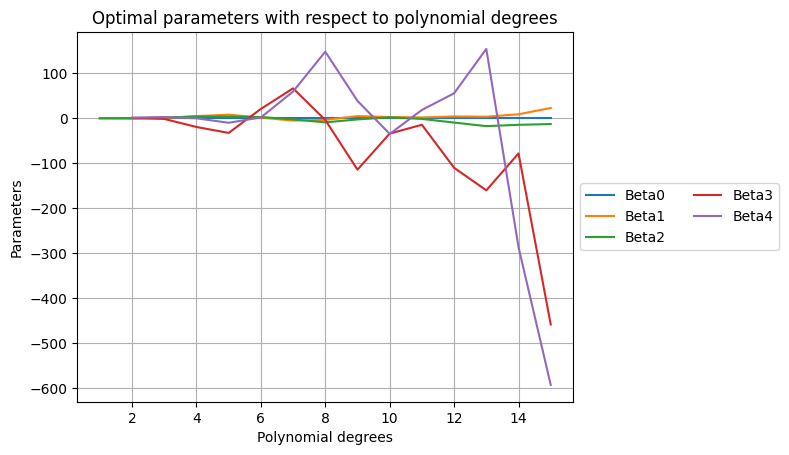

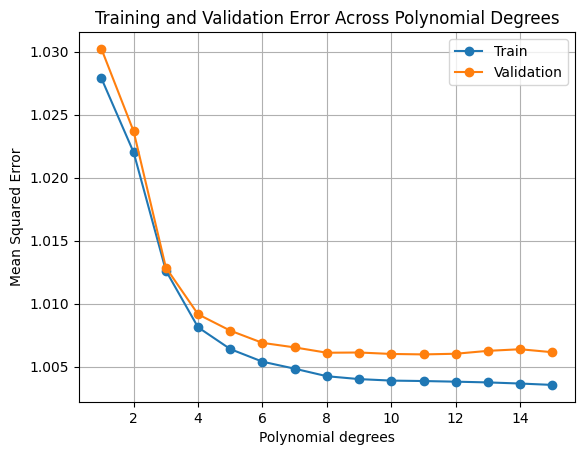

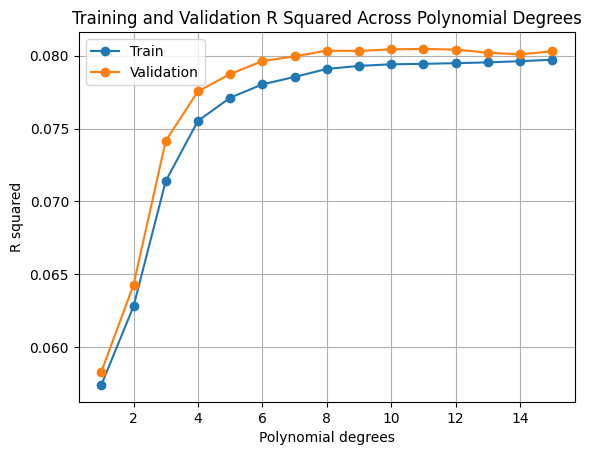

The best model has 11 degree(s) having an MSE of 1.006.
The best model has 11 degree(s) having an R Squared of 0.0805.


In [3]:
def SVDinv(A, tol=1e-10):
    ''' 
    Takes as input a numpy matrix A and returns inv(A) based on singular value decomposition (SVD).
    '''
    U, s, VT = np.linalg.svd(A, full_matrices=False)
    # Apply threshold to avoid dividing by very small singular values
    s_inv = np.array([1/si if si > tol else 0 for si in s])
    # Reconstruct the pseudoinverse
    return (VT.T @ np.diag(s_inv) @ U.T)
 
def ols(X_train, X_val, z_train, z_val,start_degree, degree, plot = False):
    ''' 
    Performs Ordinary Least Squares (OLS) regression with polynomial feature expansion.
    For polynomial degrees ranging from `start_degree` to `degree`
    Model with the lowest validation MSE is selected as the "best model". 
    
    Input Parameters:
    X_train :The training feature matrix.
    X_val :The validation feature matrix.
    z_train :The target vector for training.
    z_val :The target vector for validation.
    start_degree :The starting polynomial degree.
    degree :The maximum polynomial degree to evaluate.
    plot :Whether or not to plot beta coefficients, MSE, and R² for training and validation data.
    '''
    mse_train = []
    mse_val = []
    R2_train = []
    R2_val = []
    betas = []
    best_model = []

    for i in range(start_degree, degree + 1):
       
        # Generate polynomial features for each degree
        poly = PolynomialFeatures(degree=i)

        # Transform the original training and testing sets without overwriting
        X_train_poly = poly.fit_transform(X_train)
        X_val_poly = poly.transform(X_val)

        # Centering Data
        scaler = StandardScaler(with_std=False)
        X_train_poly[:, 1:] = scaler.fit_transform(X_train_poly[:, 1:])  # Scale only feature columns
        X_val_poly[:, 1:] = scaler.transform(X_val_poly[:, 1:])  # Scale only feature columns

        # Fit the model with the transformed features
        beta = SVDinv(X_train_poly) @ z_train
        betas.append(beta)

        # TRAIN - Calculate MSE for training data
        z_hat_train = np.dot(X_train_poly,beta)
        mse_train.append(mean_squared_error(z_train, z_hat_train))
        R2_train.append(r2_score(z_train, z_hat_train))

        # TEST - Calculate MSE for testing data
        z_hat_val = np.dot(X_val_poly,beta)
        mse_val.append(mean_squared_error(z_val, z_hat_val))
        R2_val.append(r2_score(z_val, z_hat_val))

        if mean_squared_error(z_val, z_hat_val) == min(mse_val): # Saving parameters of the best model
            best_model = beta
            

    if plot==True:
        
        # Plot beta
        for k in range(5):  # range(len(betas[-1]))
            
            k_beta = [blist[k] for blist in betas if len(blist)>k]  
             #print(k_beta)
             #print(len(k_beta))
            plt.plot([i for i in range(degree-len(k_beta)+1, degree + 1)],k_beta, label=f"Beta{k}")
            
        plt.xlabel("Polynomial degrees")
        plt.ylabel("Parameters")
        plt.title("Optimal parameters with respect to polynomial degrees")
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)
        plt.grid(True)
        #plt.savefig("SYNT_OLS_parameters.png")
        plt.show()
    
        # Plot MSE
        plt.plot([i for i in range(start_degree, degree + 1)], mse_train, label="Train", marker='o')
        plt.plot([i for i in range(start_degree, degree + 1)], mse_val, label="Validation", marker='o')
        plt.xlabel("Polynomial degrees")
        plt.ylabel("Mean Squared Error")
        plt.title("Training and Validation Error Across Polynomial Degrees")
        plt.legend()
        plt.grid(True)
        #plt.savefig("SYNT_OLS_MSE.png")
        plt.show()
        
    
        # Plot R2
        plt.plot([i for i in range(start_degree, degree + 1)], R2_train, label="Train", marker='o')
        plt.plot([i for i in range(start_degree, degree + 1)], R2_val, label="Validation", marker='o')
        plt.xlabel("Polynomial degrees")
        plt.ylabel("R squared")
        plt.title("Training and Validation R Squared Across Polynomial Degrees")
        plt.legend()
        plt.grid(True)
        #plt.savefig("SYNT_OLS_r2.png")
        plt.show()
        

    # return degree of the best model
    print(f"The best model has {mse_val.index(min(mse_val)) + start_degree} degree(s) having an MSE of {round(min(mse_val),4)}.")
    print(f"The best model has {R2_val.index(max(R2_val)) + start_degree} degree(s) having an R Squared of {round(max(R2_val),4)}.")
    return best_model,min(mse_val)


degree = 15
start_degree = 1

betas_ols = ols(X_train, X_val, z_train, z_val, start_degree, degree, True)

## Ridge with intercept

In [4]:
def Ridge(X_train,X_val,z_train,z_val,start_degree,degree, plot = False):
    
    mse_train = []
    mse_val = []
    R2_train = []
    R2_val = []
    best_lamb_mse= []
    best_lamb_R2= []
    
    for i in range(start_degree, degree+1):
        poly = PolynomialFeatures(degree=i)
        
        # Transform the original training and testing sets without overwriting
        X_train_poly = poly.fit_transform(X_train)
        X_val_poly = poly.transform(X_val)

        # Centering Data
        scaler = StandardScaler(with_std=False)
        X_train_poly[:, 1:] = scaler.fit_transform(X_train_poly[:, 1:])  # Scale only feature columns
        X_val_poly[:, 1:] = scaler.transform(X_val_poly[:, 1:])  # Scale only feature columns

        # Finding best lambda for each degree
        result = lambda_ridge(X_train_poly, X_val_poly,z_train,z_val)
        best_lamb_mse.append(result[0])
        mse_val.append(result[1])
        mse_train.append(result[2])
        R2_train.append(result[3])
        R2_val.append(result[4])
        best_lamb_R2.append(result[5])
        
        print(f"The best model with degree: {i} has a lambda:{best_lamb_mse[-1]} and a MSE:{mse_val[-1]}")
        print(f"The best model with degree: {i} has a lambda:{best_lamb_R2[-1]} and R2:{R2_val[-1]}")

        if mse_val[-1] == min(mse_val): # Saving parameters of the best model
            best_model = result[6]


    if plot==True:

        # Plot MSE
        plt.plot([i for i in range(start_degree, degree + 1)], mse_train, label="Train", marker='o')
        plt.plot([i for i in range(start_degree, degree + 1)], mse_val, label="Validation", marker='o')
        plt.xlabel("Polynomial degrees")
        plt.ylabel("Mean Squared Error")
        plt.title("Training and Validation Error Across Polynomial Degrees")
        plt.legend()
        plt.grid(True)
        plt.savefig("SYNT_ridge_MSE.png")
        plt.show()
    
        # Plot R2
        plt.plot([i for i in range(start_degree, degree + 1)], R2_train, label="Train", marker='o')
        plt.plot([i for i in range(start_degree, degree + 1)], R2_val, label="Validation", marker='o')
        plt.xlabel("Polynomial degrees")
        plt.ylabel("R squared")
        plt.title("Training and Validation R Squared Across Polynomial Degrees")
        plt.legend()
        plt.grid(True)
        plt.savefig("SYNT_ridge_r2.png")
        plt.show()

    idx = mse_val.index(min(mse_val)) 
    print(f"The best model overall, based on MSE performance, has a degree {idx+start_degree} and a MSE:{mse_val[idx]}")
        

    idx_R2 = R2_val.index(max(R2_val)) 
    print(f"The best model overall, based on R2 performance, has a degree {idx_R2+start_degree} and a R2:{R2_val[idx_R2]}")

    return best_model
    
    
def lambda_ridge(X_train_poly, X_val_poly, z_train, z_val):
    
    lambdas = [0.0001,0.001,0.01,0.1,1]
    
    mse_train = []
    mse_val = []
    R2_train = []
    R2_val = []
    

    for lmb in lambdas:
        
        # Betas optimization
        r_beta = np.linalg.inv(X_train_poly.T @ X_train_poly+lmb*np.identity(X_train_poly.shape[1])) @ X_train_poly.T @ z_train
            
        # Train
        z_hat_train = X_train_poly @ r_beta  
        mse_train.append(mean_squared_error(z_train, z_hat_train))
        R2_train.append(r2_score(z_train, z_hat_train))
    
        # Validation
        z_hat_val = X_val_poly @ r_beta
        mse_val.append(mean_squared_error(z_val, z_hat_val))
        R2_val.append(r2_score(z_val, z_hat_val))
                    
    # # Plot MSE for each lambda
    # plt.plot([i for i in lambdas], mse_train, label = "Train", marker='o')
    # plt.plot([i for i in lambdas], mse_val, label = "Validation", marker='o')
    # plt.xlabel("Lambda")
    # plt.ylabel("Mean Squared Error")
    # plt.title("MSE for training and validation data for different values of lambda")
    # plt.legend()
    # plt.grid(True)
    # plt.show()
    

    # # Plot R2 for each lambda
    # plt.plot([i for i in lambdas], R2_train, label="Train", marker='o')
    # plt.plot([i for i in lambdas], R2_val, label="Validation", marker='o')
    # plt.xlabel("Lambda")
    # plt.ylabel("R squared")
    # plt.title("R squared for training and validation data for different values of lambda")
    # plt.legend()
    # plt.grid(True)
    # plt.show()

    idx = mse_val.index(min(mse_val))
    idx_R2 = R2_val.index(max(R2_val))
    
    return lambdas[idx], min(mse_val), mse_train[idx], R2_train[idx_R2], max(R2_val), lambdas[idx_R2], r_beta

start_degree = 1
degree = 15

#betas_ridge_int = Ridge(X_train,X_val,z_train,z_val,start_degree,degree, True)

## Ridge no intercept

The best model with degree: 1 has a lambda:0.0001 and a MSE:1.3367908204366483
The best model with degree: 1 has a lambda:0.0001 and R2:0.1243895069269112
The best model with degree: 2 has a lambda:0.0001 and a MSE:1.3217813334368327
The best model with degree: 2 has a lambda:0.0001 and R2:0.13422086132564204
The best model with degree: 3 has a lambda:0.1 and a MSE:1.3319560833261368
The best model with degree: 3 has a lambda:0.1 and R2:0.1275563049632944
The best model with degree: 4 has a lambda:1 and a MSE:1.3345918182013983
The best model with degree: 4 has a lambda:1 and R2:0.12582987396268064
The best model with degree: 5 has a lambda:1 and a MSE:1.3405730654603216
The best model with degree: 5 has a lambda:1 and R2:0.12191210105347772
The best model with degree: 6 has a lambda:1 and a MSE:1.3486499382335584
The best model with degree: 6 has a lambda:1 and R2:0.11662167382780864
The best model with degree: 7 has a lambda:1 and a MSE:1.3567051327027744
The best model with degree: 

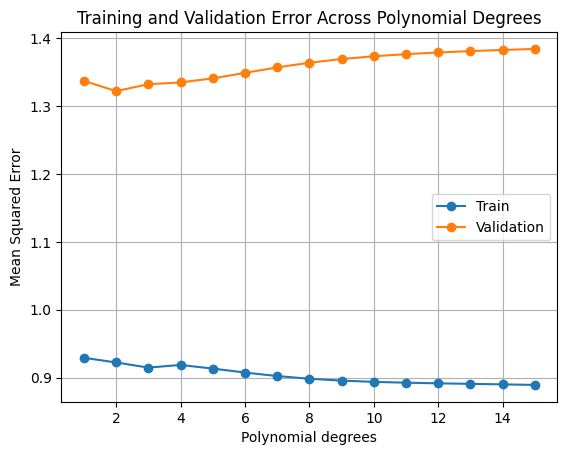

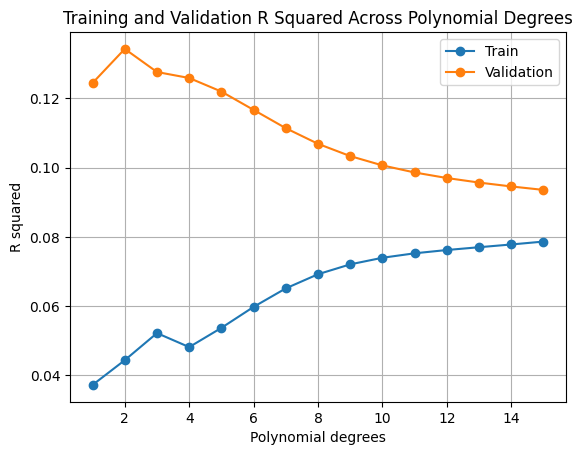

The best model overall, based on MSE performance, has a degree 2 and a MSE:1.3217813334368327
The best model overall, based on R2 performance, has a degree 2 and a R2:0.13422086132564204


In [5]:
# Make Data
np.random.seed(67)
x = np.random.rand(500,1)
y = np.random.rand(500,1)

z = FrankeFunction(x, y) + np.random.normal(0, 1, x.shape)

# Flatten the x, y, z arrays for regression
X = np.column_stack((x.ravel(), y.ravel()))
z = z.ravel() 

# Splitting into train and test
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3, random_state=32)

# Splitting into train and validation
X_train, X_val, z_train, z_val = train_test_split(X_train, z_train, test_size=0.1, random_state=32)

def Ridge_noint(X_train,X_val,z_train,z_val,start_degree,degree, plot = False):
    
    mse_train = []
    mse_val = []
    R2_train = []
    R2_val = []
    best_lamb_mse= []
    best_lamb_R2= []
    
    for i in range(start_degree, degree+1):
        poly = PolynomialFeatures(degree=i)
        
        # Transform the original training and testing sets without overwriting
        X_train_poly = poly.fit_transform(X_train)
        X_val_poly = poly.transform(X_val)

        # Centering Data
        scaler = StandardScaler(with_std=False)
        X_train_poly = scaler.fit_transform(X_train_poly)
        X_val_poly = scaler.transform(X_val_poly)

        # Removing the intercept
        X_train_poly = X_train_poly[:,1:]
        X_val_poly = X_val_poly[:,1:]
        
        result = lambda_ridge_noint(X_train_poly, X_val_poly,z_train,z_val)

        best_lamb_mse.append(result[0])
        mse_val.append(result[1])
        mse_train.append(result[2])
        R2_train.append(result[3])
        R2_val.append(result[4])
        best_lamb_R2.append(result[5])
        
        print(f"The best model with degree: {i} has a lambda:{best_lamb_mse[-1]} and a MSE:{mse_val[-1]}")
        print(f"The best model with degree: {i} has a lambda:{best_lamb_R2[-1]} and R2:{R2_val[-1]}")

        if mse_val[-1] == min(mse_val): # Saving the best model based on validation MSE
            best_model = result[6]


    if plot==True:

        # Plot MSE
        plt.plot([i for i in range(start_degree, degree + 1)], mse_train, label="Train", marker='o')
        plt.plot([i for i in range(start_degree, degree + 1)], mse_val, label="Validation", marker='o')
        plt.xlabel("Polynomial degrees")
        plt.ylabel("Mean Squared Error")
        plt.title("Training and Validation Error Across Polynomial Degrees")
        plt.legend()
        plt.grid(True)
        plt.savefig("SYNT_ridge_MSE.png")
        plt.show()
    
        # Plot R2
        plt.plot([i for i in range(start_degree, degree + 1)], R2_train, label="Train", marker='o')
        plt.plot([i for i in range(start_degree, degree + 1)], R2_val, label="Validation", marker='o')
        plt.xlabel("Polynomial degrees")
        plt.ylabel("R squared")
        plt.title("Training and Validation R Squared Across Polynomial Degrees")
        plt.legend()
        plt.grid(True)
        plt.savefig("SYNT_ridge_r2.png")
        plt.show()

    idx = mse_val.index(min(mse_val)) 
    print(f"The best model overall, based on MSE performance, has a degree {idx+start_degree} and a MSE:{mse_val[idx]}")
        

    idx_R2 = R2_val.index(max(R2_val)) 
    print(f"The best model overall, based on R2 performance, has a degree {idx_R2+start_degree} and a R2:{R2_val[idx_R2]}")

    return best_model,mse_val[idx]
    
    
def lambda_ridge_noint(X_train_poly, X_val_poly, z_train, z_val):
    
    lambdas = [0.0001,0.001,0.01,0.1,1]
    
    mse_train = []
    mse_val = []
    R2_train = []
    R2_val = []

    for lmb in lambdas:
        
        # Betas optimization
        r_beta = np.linalg.inv(X_train_poly.T @ X_train_poly+lmb*np.identity(X_train_poly.shape[1])) @ X_train_poly.T @ z_train

        #Intercept
        intercept = np.array([np.mean(z_train)- (np.mean(X_train_poly,axis = 0) @ r_beta)])
        betas = np.concatenate([intercept, r_beta])
        
        # Train
        z_hat_train = (X_train_poly @ r_beta) + intercept
        mse_train.append(mean_squared_error(z_train, z_hat_train))
        R2_train.append(r2_score(z_train, z_hat_train))
    
        # Validation
        z_hat_val = (X_val_poly @ r_beta) + intercept
        mse_val.append(mean_squared_error(z_val, z_hat_val))
        R2_val.append(r2_score(z_val, z_hat_val))
                    
    # # Plot MSE for each lambda
    # plt.plot([i for i in lambdas], mse_train, label = "Train", marker='o')
    # plt.plot([i for i in lambdas], mse_val, label = "Validation", marker='o')
    # plt.xlabel("Lambda")
    # plt.ylabel("Mean Squared Error")
    # plt.title("MSE for training and validation data for different values of lambda")
    # plt.legend()
    # plt.grid(True)
    # plt.show()
    

    # # Plot R2 for each lambda
    # plt.plot([i for i in lambdas], R2_train, label="Train")
    # plt.plot([i for i in lambdas], R2_val, label="Validation")
    # plt.xlabel("Lambda")
    # plt.ylabel("R squared")
    # plt.title("R squared for training and validation data for different values of lambda")
    # plt.legend()
    # plt.grid(True)
    # plt.show()

    idx = mse_val.index(min(mse_val))
    idx_R2 = R2_val.index(max(R2_val))
    
    return lambdas[idx], min(mse_val), mse_train[idx], R2_train[idx_R2], max(R2_val), lambdas[idx_R2], betas

start_degree=1
degree = 15

betas_ridge_noint = Ridge_noint(X_train,X_val,z_train,z_val,start_degree,degree, True)

## Lasso with intercept

In [6]:
def Lasso(X_train,X_val,z_train,z_val,start_degree, degree, plot = False):
    
    mse_train = []
    mse_val = []
    R2_train = []
    R2_val = []
    best_lamb_mse= []
    best_lamb_R2= []
    
    for i in range(start_degree,degree+1):
        
        poly = PolynomialFeatures(degree=i)
        
        # Transform the original training and testing sets without overwriting
        X_train_poly = poly.fit_transform(X_train)
        X_val_poly = poly.transform(X_val)

        # Centering Data
        scaler = StandardScaler(with_std=False)
        X_train_poly[:, 1:] = scaler.fit_transform(X_train_poly[:, 1:])  # Scale only feature columns
        X_val_poly[:, 1:] = scaler.transform(X_val_poly[:, 1:])  # Scale only feature columns
        
        result = lambda_lasso(X_train_poly, X_val_poly,z_train,z_val)
        
        best_lamb_mse.append(result[0])
        mse_val.append(result[1])
        mse_train.append(result[2])
        R2_train.append(result[3])
        R2_val.append(result[4])
        best_lamb_R2.append(result[5])
        
        print(f"The best model with degree: {i} has a lambda:{best_lamb_mse[-1]} and a MSE:{mse_val[-1]}")
        print(f"The best model with degree: {i} has a lambda:{best_lamb_R2[-1]} and R2:{R2_val[-1]}")
        
        if mse_val[-1] == min(mse_val): # Saving the best model based on validation MSE
            best_model = result[6]

    if plot==True:

        # Plot MSE
        plt.plot([i for i in range(start_degree, degree + 1)], mse_train, label="Train", marker='o')
        plt.plot([i for i in range(start_degree, degree + 1)], mse_val, label="Validation", marker='o')
        plt.xlabel("Polynomial degrees")
        plt.ylabel("Mean Squared Error")
        plt.title("Training and Validation Error Across Polynomial Degrees")
        plt.legend()
        plt.grid(True)
        plt.show()
    
        # Plot R2
        plt.plot([i for i in range(start_degree, degree + 1)], R2_train, label="Train", marker='o')
        plt.plot([i for i in range(start_degree, degree + 1)], R2_val, label="Validation", marker='o')
        plt.xlabel("Polynomial degrees")
        plt.ylabel("R squared")
        plt.title("Training and Validation R Squared Across Polynomial Degrees")
        plt.legend()
        plt.grid(True)
        plt.show()

    idx = mse_val.index(min(mse_val)) 
    print(f"The best model overall, based on MSE performance, has a degree {idx+start_degree} and a MSE:{mse_val[idx]}")
        
    idx_R2 = R2_val.index(max(R2_val)) 
    print(f"The best model overall, based on R2 performance, has a degree {idx_R2+start_degree} and a R2:{R2_val[idx_R2]}")

    return best_model

def lambda_lasso(X_train_poly, X_val_poly, z_train, z_val):
    
    lambdas = [0.0001,0.001,0.01,0.1,1]
    
    mse_train = []
    mse_val = []
    R2_train = []
    R2_val = []
    
    for lmb in lambdas:
        
        # train model
        model = linear_model.Lasso(lmb,max_iter=100000) 
        
        # fit model
        model.fit(X_train_poly, z_train)
        
        # Train
        z_hat_train = model.predict(X_train_poly)
        mse_train.append(mean_squared_error(z_train, z_hat_train))
        R2_train.append(r2_score(z_train, z_hat_train))
    
        # Validation
        z_hat_val = model.predict(X_val_poly)
        mse_val.append(mean_squared_error(z_val, z_hat_val))
        R2_val.append(r2_score(z_val, z_hat_val))
                    
    # # Plot MSE for each lambda
    # plt.plot([i for i in lambdas], mse_train, label = "Train", marker='o')
    # plt.plot([i for i in lambdas], mse_val, label = "Validation", marker='o')
    # plt.xlabel("Lambda")
    # plt.ylabel("Mean Squared Error")
    # plt.title("MSE for training and validation data for different values of lambda")
    # plt.legend()
    # plt.grid(True)
    # plt.show()
    

    # # Plot R2 for each lambda
    # plt.plot([i for i in lambdas], R2_train, label="Train", marker='o')
    # plt.plot([i for i in lambdas], R2_val, label="Validation", marker='o')
    # plt.xlabel("Lambda")
    # plt.ylabel("R squared")
    # plt.title("R squared for training and validation data for different values of lambda")
    # plt.legend()
    # plt.grid(True)
    # plt.show()
    
    idx = mse_val.index(min(mse_val))
    idx_R2 = R2_val.index(max(R2_val))
    
    return lambdas[idx], min(mse_val), mse_train[idx], R2_train[idx_R2], max(R2_val), lambdas[idx_R2], model.coef_

start_degree=1
degree = 15

#betas_lasso_int = Lasso(X_train,X_val,z_train,z_val,start_degree, degree, True)

## Lasso no intercept

The best model with degree: 1 has a lambda:0.0001 and a MSE:1.3372150895523265
The best model with degree: 1 has a lambda:0.0001 and R2:0.12411160668710164
The best model with degree: 2 has a lambda:0.0001 and a MSE:1.321857670611233
The best model with degree: 2 has a lambda:0.0001 and R2:0.13417085976227494
The best model with degree: 3 has a lambda:0.001 and a MSE:1.3323098816448131
The best model with degree: 3 has a lambda:0.001 and R2:0.12732456375477574
The best model with degree: 4 has a lambda:0.001 and a MSE:1.334329309438361
The best model with degree: 4 has a lambda:0.001 and R2:0.1260018196582412
The best model with degree: 5 has a lambda:0.001 and a MSE:1.348793077996808
The best model with degree: 5 has a lambda:0.001 and R2:0.11652791594380674
The best model with degree: 6 has a lambda:0.001 and a MSE:1.3645888669455013
The best model with degree: 6 has a lambda:0.001 and R2:0.10618152641270118
The best model with degree: 7 has a lambda:0.001 and a MSE:1.370986472865453

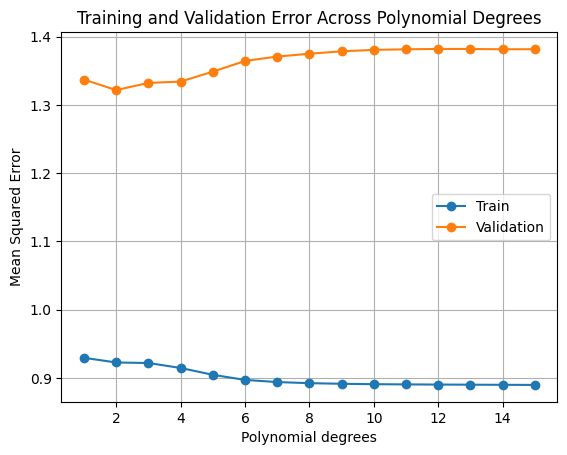

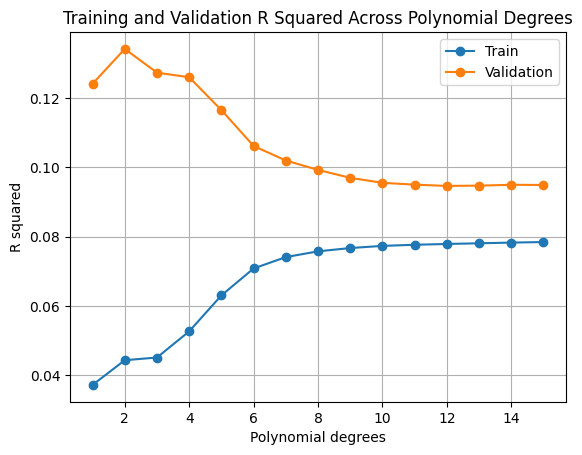

The best model overall, based on MSE performance, has a degree 2 and a MSE:1.321857670611233
The best model overall, based on R2 performance, has a degree 2 and a R2:0.13417085976227494


In [7]:
def Lasso_noint(X_train,X_val,z_train,z_val,start_degree, degree, plot = False):
    
    mse_train = []
    mse_val = []
    R2_train = []
    R2_val = []
    best_lamb_mse= []
    best_lamb_R2= []
    
    for i in range(start_degree,degree+1):
        
        poly = PolynomialFeatures(degree=i)
        
        # Transform the original training and testing sets without overwriting
        X_train_poly = poly.fit_transform(X_train)
        X_val_poly = poly.transform(X_val)

        # Centering Data
        scaler = StandardScaler(with_std=False)
        X_train_poly = scaler.fit_transform(X_train_poly)
        X_val_poly = scaler.transform(X_val_poly)

        # Removing the intercept
        X_train_poly = X_train_poly[:,1:]
        X_val_poly = X_val_poly[:,1:]
        
        result = lambda_lasso_noint(X_train_poly, X_val_poly,z_train,z_val)
        
        best_lamb_mse.append(result[0])
        mse_val.append(result[1])
        mse_train.append(result[2])
        R2_train.append(result[3])
        R2_val.append(result[4])
        best_lamb_R2.append(result[5])
        
        print(f"The best model with degree: {i} has a lambda:{best_lamb_mse[-1]} and a MSE:{mse_val[-1]}")
        print(f"The best model with degree: {i} has a lambda:{best_lamb_R2[-1]} and R2:{R2_val[-1]}")
        
        if mse_val[-1] == min(mse_val): # Saving the best model based on validation MSE
            best_model = result[6]

    if plot==True:

        # Plot MSE
        plt.plot([i for i in range(start_degree, degree + 1)], mse_train, label="Train", marker='o')
        plt.plot([i for i in range(start_degree, degree + 1)], mse_val, label="Validation", marker='o')
        plt.xlabel("Polynomial degrees")
        plt.ylabel("Mean Squared Error")
        plt.title("Training and Validation Error Across Polynomial Degrees")
        plt.legend()
        plt.grid(True)
        plt.savefig("SYNT_lasso_MSE.png")
        plt.show()
    
        # Plot R2
        plt.plot([i for i in range(start_degree, degree + 1)], R2_train, label="Train", marker='o')
        plt.plot([i for i in range(start_degree, degree + 1)], R2_val, label="Validation", marker='o')
        plt.xlabel("Polynomial degrees")
        plt.ylabel("R squared")
        plt.title("Training and Validation R Squared Across Polynomial Degrees")
        plt.legend()
        plt.grid(True)
        plt.savefig("SYNT_lasso_MSE.png")
        plt.show()

    idx = mse_val.index(min(mse_val)) 
    print(f"The best model overall, based on MSE performance, has a degree {idx+start_degree} and a MSE:{mse_val[idx]}")
    
    idx_R2 = R2_val.index(max(R2_val)) 
    print(f"The best model overall, based on R2 performance, has a degree {idx_R2+start_degree} and a R2:{R2_val[idx_R2]}")

    return best_model,mse_val[idx]


def lambda_lasso_noint(X_train_poly, X_val_poly, z_train, z_val):
    
    lambdas = [0.0001,0.001,0.01,0.1,1]
    
    mse_train = []
    mse_val = []
    R2_train = []
    R2_val = []
    
    for lmb in lambdas:
        
        # train model
        model = linear_model.Lasso(lmb,max_iter=100000, fit_intercept = False) 
        
        # fit model
        model.fit(X_train_poly, z_train)

        # Intercept
        intercept = np.array([np.mean(z_train)- (np.mean(X_train_poly,axis = 0) @ model.coef_)])
        betas = np.concatenate([intercept, model.coef_])
        
        # Train
        z_hat_train = model.predict(X_train_poly) + intercept
        mse_train.append(mean_squared_error(z_train, z_hat_train))
        R2_train.append(r2_score(z_train, z_hat_train))
        
        # Validation
        z_hat_val = model.predict(X_val_poly) + intercept
        mse_val.append(mean_squared_error(z_val, z_hat_val))
        R2_val.append(r2_score(z_val, z_hat_val))
                    
    # # Plot MSE for each lambda
    # plt.plot([i for i in lambdas], mse_train, label = "Train", marker='o')
    # plt.plot([i for i in lambdas], mse_val, label = "Validation", marker='o')
    # plt.xlabel("Lambda")
    # plt.ylabel("Mean Squared Error")
    # plt.title("MSE for training and validation data for different values of lambda")
    # plt.legend()
    # plt.grid(True)
    # plt.show()
    

    # # Plot R2 for each lambda
    # plt.plot([i for i in lambdas], R2_train, label="Train", marker='o')
    # plt.plot([i for i in lambdas], R2_val, label="Validation", marker='o')
    # plt.xlabel("Lambda")
    # plt.ylabel("R squared")
    # plt.title("R squared for training and validation data for different values of lambda")
    # plt.legend()
    # plt.grid(True)
    # plt.show()
    
    idx = mse_val.index(min(mse_val))
    idx_R2 = R2_val.index(max(R2_val))
    
    return lambdas[idx], min(mse_val), mse_train[idx], R2_train[idx_R2], max(R2_val), lambdas[idx_R2], betas

start_degree=1
degree = 15

betas_lasso_noint = Lasso_noint(X_train,X_val,z_train,z_val,start_degree, degree,True)

## Part E Bootstrap

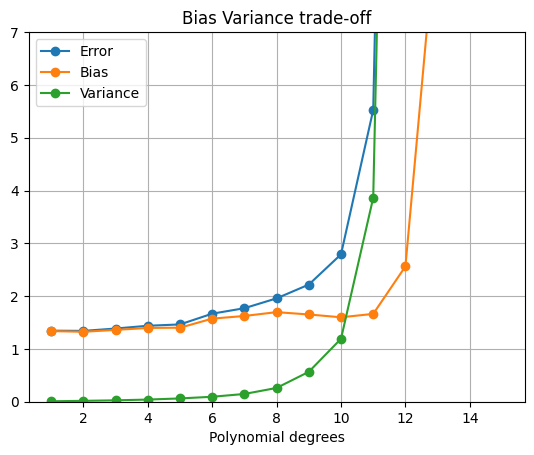

The best model has 2 degree(s) with an MSE of 1.3416.


In [8]:
def ols_bootstrap(X_train, X_val, z_train, z_val, start_degree, degree, n_boostraps, plot=False):

    # z_val needs to have a column for dimensionality problems
    z_val = z_val[:, np.newaxis]

    # Error, bias e variance
    error = np.zeros(degree)
    bias = np.zeros(degree)
    variance = np.zeros(degree)

    for d in range(start_degree, degree + 1):
        # New features
        poly = PolynomialFeatures(degree=d)

        # Adding new features
        X_train_poly = poly.fit_transform(X_train)
        X_val_poly = poly.transform(X_val)

        # Centering Data
        scaler = StandardScaler(with_std=False)
        X_train_poly[:, 1:] = scaler.fit_transform(X_train_poly[:, 1:])  # Scale only feature columns
        X_val_poly[:, 1:] = scaler.transform(X_val_poly[:, 1:])  # Scale only feature columns

        # Creating a model
        poly_model = LinearRegression(fit_intercept=False)

        # Bootstrap
        z_pred = np.empty((z_val.shape[0], n_boostraps))
        
        for i in range(n_boostraps):
            X_resampled, z_resampled = resample(X_train_poly, z_train)
            z_pred[:, i] = poly_model.fit(X_resampled, z_resampled).predict(X_val_poly).ravel()

        # Computation of errore, bias e variance for each degree
        error[d - start_degree] = np.mean(np.mean((z_val - z_pred) ** 2, axis=1, keepdims=True))
        bias[d - start_degree] = np.mean((z_val - np.mean(z_pred, axis=1, keepdims=True)) ** 2)
        variance[d - start_degree] = np.mean(np.var(z_pred, axis=1, keepdims=True))

        if error[d - start_degree] == np.min(error[error != 0]):
            best_model = poly_model

    # Plot 
    if plot:
        plt.plot([i for i in range(start_degree, degree + 1)], error, label='Error', marker='o')
        plt.plot([i for i in range(start_degree, degree + 1)], bias, label='Bias', marker='o')
        plt.plot([i for i in range(start_degree, degree + 1)], variance, label='Variance', marker='o')
        plt.xlabel("Polynomial degrees")
        plt.title("Bias Variance trade-off")
        plt.ylim(0,7)
        plt.legend()
        plt.grid(True)
        plt.savefig("SYNT_bootstrap.png")
        plt.show()
        
    print(f"The best model has {np.argmin(error[error != 0]) + start_degree} degree(s) with an MSE of {round(np.min(error), 4)}.")
    return best_model

n_boostraps = 500
start_degree = 1
degree = 15

ols_bootstrap = ols_bootstrap(X_train, X_val, z_train, z_val, start_degree, degree, n_boostraps, True)

## Part F Cross Validation

In [2]:
# Make Data
np.random.seed(67)
x = np.random.rand(500,1)
y = np.random.rand(500,1)

z = FrankeFunction(x, y) + np.random.normal(0, 1, x.shape)

# Flatten the x, y, z arrays for regression
X = np.column_stack((x.ravel(), y.ravel()))
z = z.ravel()

# Splitting into train and test
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3, random_state=32)

### OLS CV

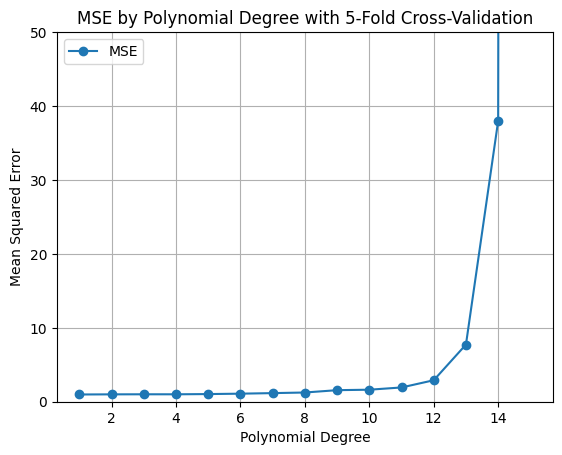

The best model has 1 degree(s) with an MSE of 0.9786.


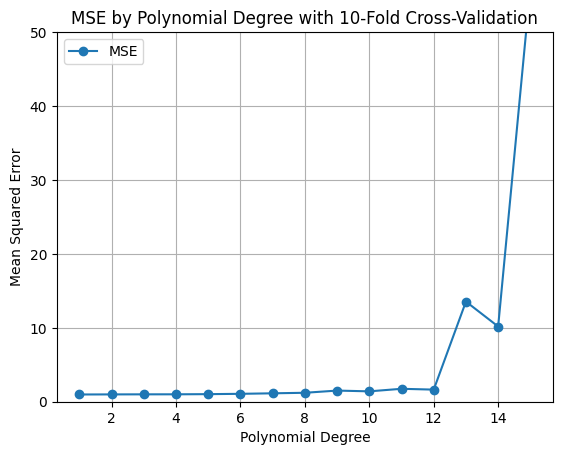

The best model has 1 degree(s) with an MSE of 0.9788.


In [10]:
def ols_CV(X_train, z_train, start_degree, degree, folds, plot=False):

    scores = np.zeros(degree)

    for d in range(start_degree, degree + 1):
        # New features
        poly = PolynomialFeatures(degree=d)

        # Adding new features
        X_train_poly = poly.fit_transform(X_train)

        # Centering data
        scaler = StandardScaler(with_std=False)
        X_train_poly[:, 1:] = scaler.fit_transform(X_train_poly[:, 1:]) # Scale only feature columns

        # Creating a model
        poly_model = LinearRegression(fit_intercept=False)

        # Cross Validation
        cv_scores = cross_val_score(poly_model, X_train_poly, z_train, cv=folds, scoring="neg_mean_squared_error")
        scores[d - start_degree] = np.mean(-cv_scores)
        
    # Plot 
    if plot:
        plt.plot([i for i in range(start_degree, degree + 1)], scores, label='MSE', marker='o')
        plt.xlabel("Polynomial Degree")
        plt.ylabel("Mean Squared Error")
        plt.title(f"MSE by Polynomial Degree with {folds}-Fold Cross-Validation")
        plt.legend()
        plt.ylim(0,50)
        plt.grid(True)
        #plt.savefig(f"SYNT_CV{folds}_OLS.png")
        plt.show()

    print(f"The best model has {np.argmin(scores) + start_degree} degree(s) with an MSE of {round(np.min(scores), 4)}.")

folds = [5,10]
start_degree = 1
degree = 15

for fold in folds:
    ols_CV(X_train, z_train, start_degree, degree, fold, True)

## Ridge CV

The best model with degree = 1 has a lambda = 1 and a MSE = 0.9782353560084994
The best model with degree = 2 has a lambda = 1 and a MSE = 0.986516934689039
The best model with degree = 3 has a lambda = 1 and a MSE = 0.9899774852936012
The best model with degree = 4 has a lambda = 1 and a MSE = 0.9912571522291316
The best model with degree = 5 has a lambda = 1 and a MSE = 0.9916416337025945
The best model with degree = 6 has a lambda = 1 and a MSE = 0.9916390103998882
The best model with degree = 7 has a lambda = 1 and a MSE = 0.9916286325816422
The best model with degree = 8 has a lambda = 1 and a MSE = 0.9918768499918492
The best model with degree = 9 has a lambda = 1 and a MSE = 0.9924945643990913
The best model with degree = 10 has a lambda = 1 and a MSE = 0.9934766023288256
The best model with degree = 11 has a lambda = 1 and a MSE = 0.9947596986591958
The best model with degree = 12 has a lambda = 1 and a MSE = 0.9962627037213523
The best model with degree = 13 has a lambda = 1 a

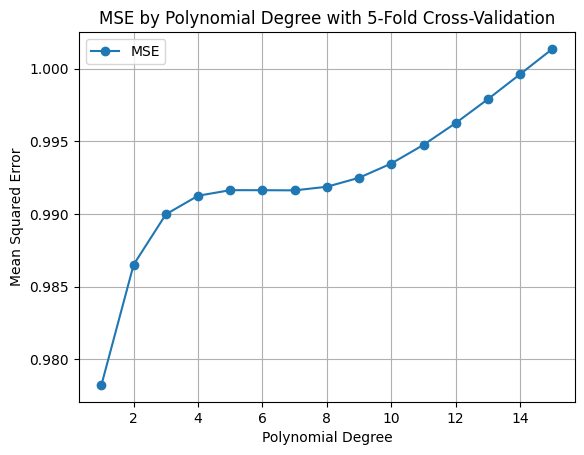

The best model overall, based on MSE performance, has: a degree 1, a MSE = 0.9782353560084994 and lambda = 1
The best model with degree = 1 has a lambda = 1 and a MSE = 0.9786308011064808
The best model with degree = 2 has a lambda = 1 and a MSE = 0.9835109248077443
The best model with degree = 3 has a lambda = 1 and a MSE = 0.985593397836818
The best model with degree = 4 has a lambda = 1 and a MSE = 0.9858865938303325
The best model with degree = 5 has a lambda = 1 and a MSE = 0.9849588068038877
The best model with degree = 6 has a lambda = 1 and a MSE = 0.9835688796584913
The best model with degree = 7 has a lambda = 1 and a MSE = 0.9824762377935666
The best model with degree = 8 has a lambda = 1 and a MSE = 0.9821203482681302
The best model with degree = 9 has a lambda = 1 and a MSE = 0.9825942202581806
The best model with degree = 10 has a lambda = 1 and a MSE = 0.9837838782047117
The best model with degree = 11 has a lambda = 1 and a MSE = 0.9855004385205477
The best model with d

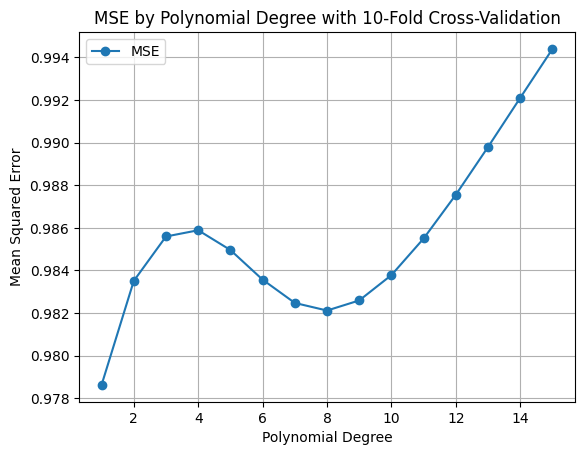

The best model overall, based on MSE performance, has: a degree 1, a MSE = 0.9786308011064808 and lambda = 1


In [3]:
def RidgeCV(X_train,z_train,start_degree,degree, folds, plot = False):
    
    tot_scores = []
    best_lambda = []
    
    for i in range(start_degree, degree+1):
        poly = PolynomialFeatures(degree=i)
        
        # Transform the original training and testing sets without overwriting
        X_train_poly = poly.fit_transform(X_train)

        # Centering data
        scaler = StandardScaler(with_std=False)
        X_train_poly[:, 1:] = scaler.fit_transform(X_train_poly[:, 1:]) # Scale only feature columns

        if plot:
            score = lambda_ridge_cv(X_train_poly,z_train,i, folds,True)    
        else:
            score = lambda_ridge_cv(X_train_poly,z_train,i, folds)
       
        tot_scores.append(score[0])
        best_lambda.append(score[1])

    if plot:
        # Complexity and MSE plot 
        plt.plot([i for i in range(start_degree, degree + 1)], tot_scores, label="MSE", marker='o')
        plt.xlabel("Polynomial Degree")
        plt.ylabel("Mean Squared Error")
        plt.title(f"MSE by Polynomial Degree with {folds}-Fold Cross-Validation")
        plt.legend()
        plt.grid(True)
        plt.savefig(f"SYNT_CV{folds}_RIDGE.png")
        plt.show()

    idx = tot_scores.index(min(tot_scores)) 
    print(f"The best model overall, based on MSE performance, has: a degree {idx+start_degree}, a MSE = {min(tot_scores)} and lambda = {best_lambda[idx]}")
        
    return idx+start_degree, min(tot_scores), best_lambda[idx]
    
def lambda_ridge_cv(X_train_poly, z_train, degree, folds, plot = False):
    
    lambdas = [0.0001,0.001,0.01,0.1,1]
    scores = []

    for lmb in lambdas:

        model = Ridge(alpha=lmb, fit_intercept = False)

        cv_scores = cross_val_score(model, X_train_poly, z_train, cv= folds, scoring = "neg_mean_squared_error")
        scores.append(np.mean(-cv_scores))

    # if plot:
    #     # Plot MSE
    #     plt.plot([i for i in lambdas], scores, label = "MSE")
    #     plt.xlabel("Lambda")
    #     plt.ylabel("Mean Squared Error")
    #     plt.title(f" degree = {degree}")
    #     plt.legend()
    #     plt.show()
    
    print(f"The best model with degree = {degree} has a lambda = {lambdas[np.argmin(scores)]} and a MSE = {np.min(scores)}")

    return np.min(scores),lambdas[np.argmin(scores)]

folds = [5,10]
start_degree = 1
degree = 15
for fold in folds:
    RidgeCV(X_train, z_train, start_degree, degree, fold, True)

## Lasso CV 

The best model with degree = 1 has a lambda = 0.0001 and a MSE = 0.9786112797306485
The best model with degree = 2 has a lambda = 0.01 and a MSE = 0.988113247901474
The best model with degree = 3 has a lambda = 0.01 and a MSE = 0.9904363536352221
The best model with degree = 4 has a lambda = 0.01 and a MSE = 0.9904363526513544
The best model with degree = 5 has a lambda = 0.01 and a MSE = 0.9904363526513544
The best model with degree = 6 has a lambda = 0.01 and a MSE = 0.9904363526513544
The best model with degree = 7 has a lambda = 0.01 and a MSE = 0.9904363526513544
The best model with degree = 8 has a lambda = 0.01 and a MSE = 0.9904363526513544
The best model with degree = 9 has a lambda = 0.01 and a MSE = 0.9904363526513544
The best model with degree = 10 has a lambda = 0.01 and a MSE = 0.9904363526513544
The best model with degree = 11 has a lambda = 0.01 and a MSE = 0.9904363526513544
The best model with degree = 12 has a lambda = 0.01 and a MSE = 0.9904363526513544
The best mod

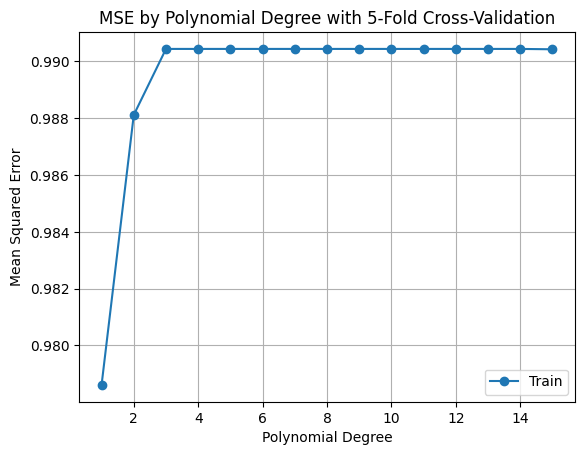

The best model overall, based on MSE performance, has: a degree 1, a MSE = 0.9786112797306485 and lambda = 0.0001
The best model with degree = 1 has a lambda = 0.0001 and a MSE = 0.9787965925267667
The best model with degree = 2 has a lambda = 0.001 and a MSE = 0.9844268119837094
The best model with degree = 3 has a lambda = 0.01 and a MSE = 0.9906762065854883
The best model with degree = 4 has a lambda = 0.001 and a MSE = 0.9903481778580069
The best model with degree = 5 has a lambda = 0.001 and a MSE = 0.9869938369843385
The best model with degree = 6 has a lambda = 0.001 and a MSE = 0.9838143445605384
The best model with degree = 7 has a lambda = 0.001 and a MSE = 0.9816926893712589
The best model with degree = 8 has a lambda = 0.001 and a MSE = 0.9819489620319924
The best model with degree = 9 has a lambda = 0.001 and a MSE = 0.9827424142272149
The best model with degree = 10 has a lambda = 0.001 and a MSE = 0.9849847533643648
The best model with degree = 11 has a lambda = 0.001 an

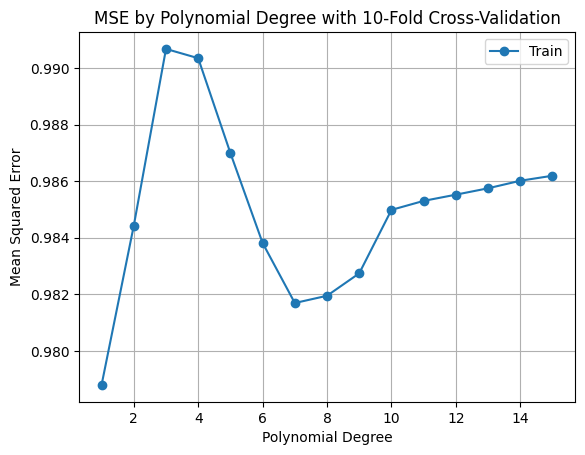

The best model overall, based on MSE performance, has: a degree 1, a MSE = 0.9787965925267667 and lambda = 0.0001


In [4]:
def LassoCV(X_train,z_train,start_degree,degree, folds, plot = False):
    
    tot_scores = []
    best_lambda = []
    
    for i in range(start_degree, degree+1):
        poly = PolynomialFeatures(degree=i)
        
        # Transform the original training and testing sets without overwriting
        X_train_poly = poly.fit_transform(X_train)

        # Centering data
        scaler = StandardScaler(with_std=False)
        X_train_poly[:, 1:] = scaler.fit_transform(X_train_poly[:, 1:]) # Scale only feature columns

        if plot:
            score = lambda_lasso_cv(X_train_poly,z_train,i,folds, True)
        else:
            score = lambda_lasso_cv(X_train_poly,z_train,i,folds)
       
        tot_scores.append(score[0])
        best_lambda.append(score[1])

    if plot:
        # Complexity and MSE plot 
        plt.plot([i for i in range(start_degree, degree + 1)], tot_scores, label="Train", marker='o')
        plt.xlabel("Polynomial Degree")
        plt.ylabel("Mean Squared Error")
        plt.title(f"MSE by Polynomial Degree with {folds}-Fold Cross-Validation")
        plt.legend()
        plt.grid(True)
        plt.savefig(f"SYNT_CV{folds}_LASSO.png")
        plt.show()
    
    idx = tot_scores.index(min(tot_scores)) 
    print(f"The best model overall, based on MSE performance, has: a degree {idx+start_degree}, a MSE = {min(tot_scores)} and lambda = {best_lambda[idx]}")

    return idx+start_degree, min(tot_scores), best_lambda[idx]
    
    
def lambda_lasso_cv(X_train_poly, z_train, degree, folds, plot = False):
    
    lambdas = [0.0001,0.001,0.01,0.1,1]
    scores = []

    for lmb in lambdas:

        model = Lasso(alpha=lmb,max_iter=10000, fit_intercept = False)

        cv_scores = cross_val_score(model, X_train_poly, z_train, cv= folds, scoring = "neg_mean_squared_error")
        scores.append(np.mean(-cv_scores))

    # if plot:
    #     # Plot MSE
    #     plt.plot([i for i in lambdas], scores, label = "MSE", marker='o')
    #     plt.xlabel("Lambda")
    #     plt.ylabel("Mean Squared Error")
    #     plt.title(f" degree = {degree}")
    #     plt.legend()
    #     plt.show()

    print(f"The best model with degree = {degree} has a lambda = {lambdas[np.argmin(scores)]} and a MSE = {np.min(scores)}")

    return np.min(scores),lambdas[np.argmin(scores)]

folds = [5,10]
start_degree = 1
degree = 15


# Ignore all ConvergenceWarning
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

for fold in folds:
    LassoCV(X_train, z_train, start_degree, degree, fold, True)

# Tables of method and respective MSE 

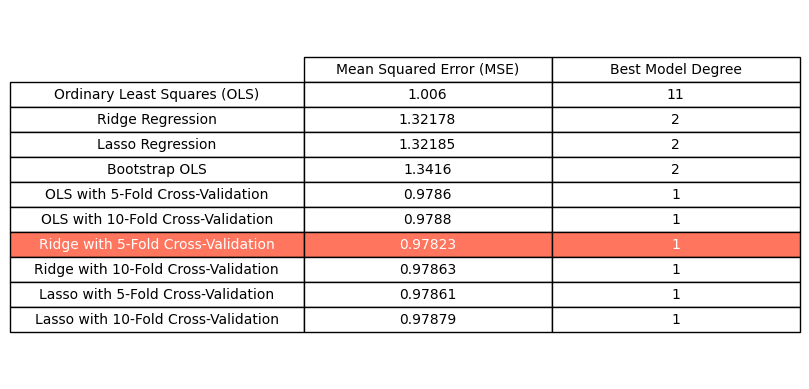

In [5]:
# Data for the table
columns = ('Mean Squared Error (MSE)', 'Best Model Degree')
rows = ['Ordinary Least Squares (OLS)', 
        'Ridge Regression', 
        'Lasso Regression', 
        'Bootstrap OLS', 
        'OLS with 5-Fold Cross-Validation', 
        'OLS with 10-Fold Cross-Validation', 
        'Ridge with 5-Fold Cross-Validation', 
        'Ridge with 10-Fold Cross-Validation', 
        'Lasso with 5-Fold Cross-Validation', 
        'Lasso with 10-Fold Cross-Validation']
data = [[1.00600, 11],
        [1.32178, 2],
        [1.32185, 2],
        [1.34160, 2],
        [0.97860,1],
        [0.97880, 1],
        [0.97823, 1],
        [0.97863, 1],
        [0.97861, 1],
        [0.97879, 1]]

fig, ax = plt.subplots()

# Hide axes
ax.axis('tight')
ax.axis('off')

# Table
table = ax.table(cellText=data, colLabels=columns, rowLabels=rows, loc='center')

table.scale(1, 1.5)

# Settng larger space for row labels and centering of the text
for key, cell in table.get_celld().items():
    cell.get_text().set_horizontalalignment('center')  
    cell.get_text().set_verticalalignment('center')  
    if key[1] == -1:  
        cell.set_width(0.2)  

# Cell having minimum MSE value
mse_values = [row[0] for row in data]
min_mse = min(mse_values)
min_index = mse_values.index(min_mse)


table[(min_index+1, 0)].set_facecolor('#ff755d') 
table[(min_index+1, 0)].set_text_props(color='white') 
table[(min_index+1, 1)].set_facecolor('#ff755d') 
table[(min_index+1, 1)].set_text_props(color='white') 
table[(min_index+1, -1)].set_facecolor('#ff755d') 
table[(min_index+1, -1)].set_text_props(color='white')  

#plt.savefig("SYNT_tablesmall.png", bbox_inches='tight', dpi=300)  # Ensure tight bounding box
plt.show()


# Performance evaluation on TEST 

In [7]:
# Make data
np.random.seed(67)
x = np.random.rand(500,1)
y = np.random.rand(500,1)

x, y = np.meshgrid(x, y)

z = FrankeFunction(x, y) + np.random.normal(0, 1, x.shape)

# Flatten the x, y, z arrays for regression
X = np.column_stack((x.ravel(), y.ravel()))
z = z.ravel() 

# Splitting into train and test
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3, random_state=32)

In [8]:
best_degree = 1  # As per your cross-validation results
best_lambda = 1  # Lambda for the Ridge Regression

# Polynomial features for the best degree
poly = PolynomialFeatures(degree=best_degree)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Centering 
scaler = StandardScaler(with_std=False)
X_train_poly[:, 1:] = scaler.fit_transform(X_train_poly[:, 1:])  
X_test_poly[:, 1:] = scaler.transform(X_test_poly[:, 1:])       

# Training
ridge_model = Ridge(alpha=best_lambda, fit_intercept=False)
ridge_model.fit(X_train_poly, z_train)

# Prediction on test
z_pred_test = ridge_model.predict(X_test_poly)

# Performance evaluation
mse_test = mean_squared_error(z_test, z_pred_test)
print(f"Mean Squared Error on the Test Set: {mse_test}")

# Optimal coefficient 
print(f"Optimal Parameters: {ridge_model.coef_}")

Mean Squared Error on the Test Set: 1.0118372301224263
Optimal Parameters: [ 0.41012304 -0.48710352 -0.73224729]
